In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta = '/content/drive/MyDrive/Machine Learning/Proyecto 1/HealthInsurance/insuranceDB.csv'
dataInsurance = pd.read_csv(ruta)
dataInsurance[:]

FileNotFoundError: ignored

In [ ]:
dataInsurance.describe()

NameError: ignored

In [ ]:
dataInsurance.info()

In [ ]:
dataInsurance[['sex', 'smoker', 'region']] = dataInsurance[['sex', 'smoker', 'region']].astype('category')

In [ ]:
dataInsurance.info()

In [ ]:
sex = dataInsurance['sex'].replace(['female','male'],[0.,1.])

In [ ]:
dataInsurance['region'] = dataInsurance['region'].astype('category')
dataInsurance['region_cat'] = dataInsurance['region'].cat.codes
dataInsurance['sex'] = dataInsurance['sex'].astype('category')
dataInsurance['sex_cat'] = dataInsurance['sex'].cat.codes
dataInsurance['smoker'] = dataInsurance['smoker'].astype('category')
dataInsurance['smoker_cat'] = dataInsurance['smoker'].cat.codes
print(dataInsurance.dtypes)
dataInsurance

In [ ]:
from csv import field_size_limit

In [ ]:
X = dataInsurance[['region_cat']].astype(float)
X.dtypes
# Convertimos a numpy arra
X = X.values
# 2. Las etiquetas t (N*D), en este caso modelaremos los charges del seguro
t = dataInsurance['charges'].values
plt.figure(figsize=(12,4))
plt.stem(t[:200])
plt.show()

In [ ]:
def polyFBase(obs,M):
  idx = np.linspace(0,M-1,M)
  phi_x = np.power(obs,idx)
  return phi_x

def expFBase(obs,M):
  # La idea es que el rango del vector de medias
  # este contenido en el rango de x
  mu_s = np.linspace(0,908.,M) # El máximo es el número de días temporales
  s2 = 0.5
  phi_x = np.zeros_like(mu_s)
  for m in range(0,len(mu_s)):
    phi_x[m] = np.exp(-((obs-mu_s[m])**2)/(2*s2))
  phi_x[0] = 1.
  return phi_x

  #Aqui se agrego la funcion sigmoidal //
def sigFBase(obs, M):
  mu_s = np.linspace(0,500.,M)
  s = 0.05
  phi_x = np.zeros_like(mu_s)
  for m in range(0,len(mu_s)):
    phi_x[m] = 1/(1+(np.exp(-(obs-mu_s[m])/(s))))
  phi_x[0] = 1.
  return phi_x

In [ ]:
region_cat = X
N = np.shape(np.ravel(region_cat))
N = N[0]
xregion_cat = np.linspace(0,N,N)

def matrixPHIDesign(x_vect,M,fbase):
  N = len(x_vect)
  mPHI = np.zeros((N,M))
  for n in range(0,N):
    x_n = x_vect[n] # seleccionamos cada observacion
    if fbase == 'poly':
      vectPhi_xn = polyFBase(x_n,M)
    if fbase == 'exp':
      vectPhi_xn = expFBase(x_n,M)
    if fbase == "sig":  #se agrega llamado a funcion sigmoidal //
      vectPhi_xn = sigFBase(x_n,M)
    mPHI[n,:] = vectPhi_xn
  return mPHI

charges = dataInsurance['charges'] # modelar el número de casos para el LAB

In [ ]:
xNuevos = np.linspace(500,250,50)

In [ ]:
x_train = xregion_cat
y_train = charges
x_test = xNuevos

aux = np.isnan(y_train)
pos = np.where(aux==True)
y_train.iloc[pos[0]] = 0.

In [ ]:
nuestraFBase = False
if nuestraFBase == True:
  FlagFitNewData = True
  if FlagFitNewData == True:
    x_test = np.linspace(1288,1388,100)
  else:
    x_test = x_train
  X_train = matrixPHIDesign(x_train,M = 1338,fbase='exp')
  X_test = matrixPHIDesign(x_test,M = 50,fbase='exp')
else:
  n_order = 8
  X_train = np.vander(x_train, n_order + 1, increasing=True)
  X_test = np.vander(x_test, n_order + 1, increasing=True)

In [ ]:
reg = BayesianRidge(tol=1e-6, fit_intercept=True, compute_score=True)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
for i, ax in enumerate(axes):
    # Bayesian ridge regression with different initial value pairs
    if i == 0:
        init = [1 / np.var(y_train), 1.]  # Default values
    elif i == 1:
        init = [1., 1e-4]
        reg.set_params(alpha_init=init[0], lambda_init=init[1])
    reg.fit(X_train, y_train)
    # we compute both mean and std as a form of uncertainty
    ymean, ystd = reg.predict(X_train, return_std=True)
    ymeanTest, ystdTest = reg.predict(X_test, return_std=True)

    ax.scatter(x_train, y_train, s=80, alpha=0.9, label="observation")
    ax.plot(x_train, ymean, color="red", label="predict mean")
    ax.fill_between(x_train, ymean-ystd, ymean+ystd,
                    color="pink", alpha=0.5, label="predict std")
    # ax.plot(x_test, ymeanTest, color="yellow", label="predict mean Test")
    # ax.fill_between(x_test, ymeanTest-ystdTest, ymeanTest+ystdTest,
    #                 color="green", alpha=0.5, label="predict std Test")
    #ax.set_ylim(-1.3, 1.3)
    ax.legend()
    title = "$\\alpha$_init$={:.2f},\\ \\lambda$_init$={}$".format(
            init[0], init[1])
    if i == 0:
        title += " (Default) "
    ax.set_title(title, fontsize=12)
    text = "$\\alpha={:.1f}$\n$\\lambda={:.3f}$\n$L={:.1f}$".format(
           reg.alpha_, reg.lambda_, reg.scores_[-1])
    ax.text(0.05, -1.0, text, fontsize=12)

plt.tight_layout()
plt.show()

r2 = r2_score(y_train,ymean)
errorMSE = mean_squared_error(y_train,ymean)
errorMAE = mean_absolute_error(y_train,ymean)
print("Error de predicción R2 es: ",r2)
print("Error de predicción MSE es: ",errorMSE)
print("Error de predicción MAE es: ",errorMAE)


# Conclusiones

La variable de orden con valor 6 la predicción da desfasada debido a que tiende al infinito.
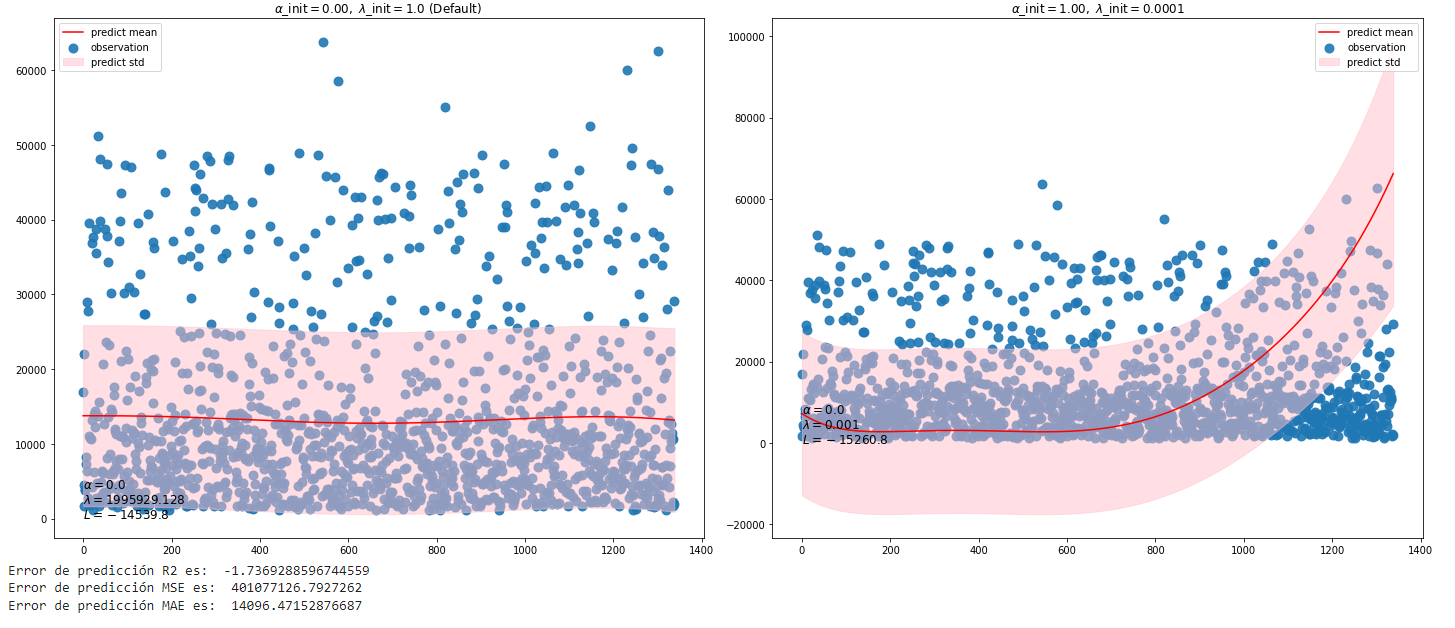

La variable de orden con valor a 8
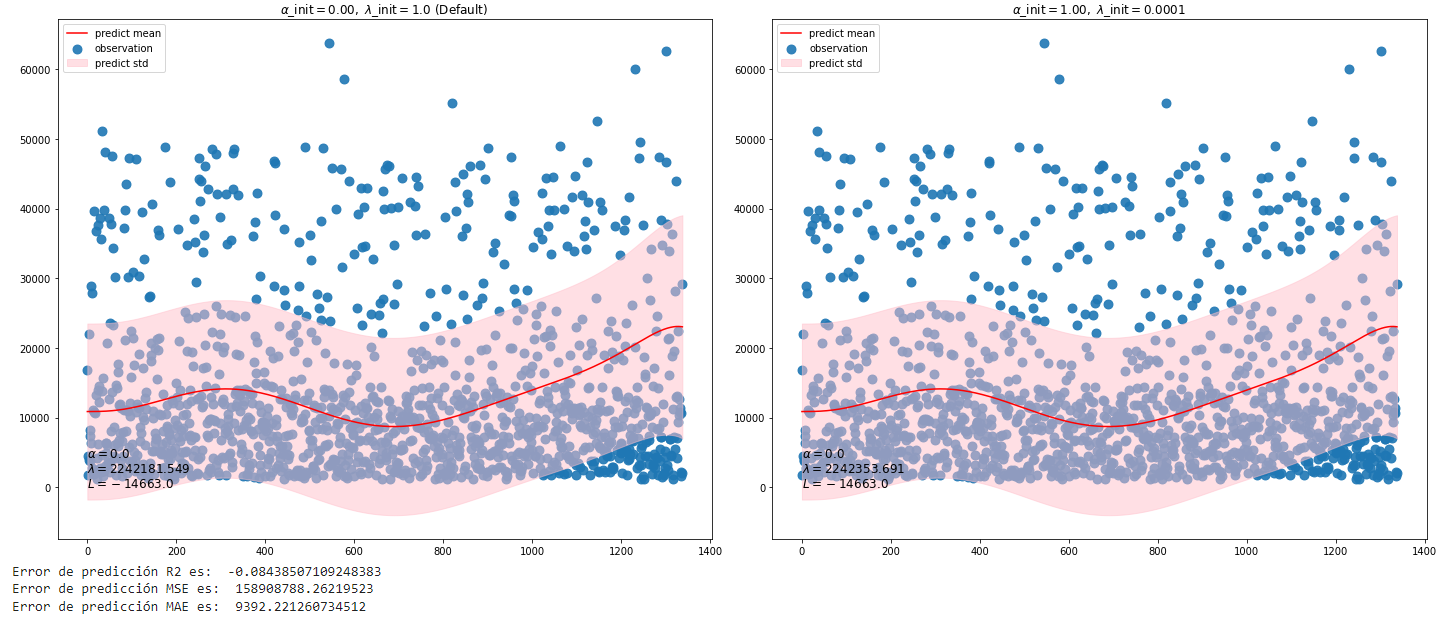

La variable de orden con valor de 7 es la mejor predicción

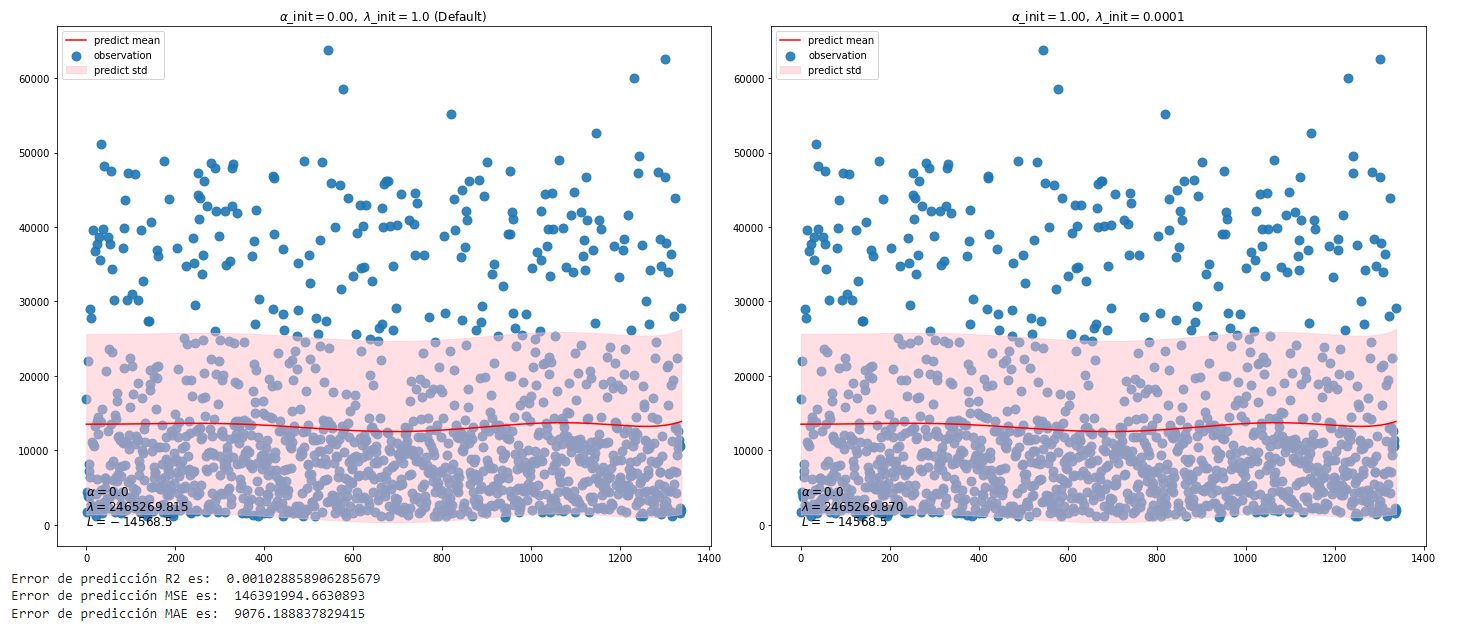

* Los Errores R2, MSE y MAE son los más bajos que los valores anteriores
*Si en la variable orden tenemos un valor diferente ya se desfasn mucho los errores y da con valores negativos y con tendencia al infinito.